In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Hyperparameters
batch_size = 64
num_epochs = 100
learning_rate = 0.0002
latent_dim = 100
num_generators = 5
beta = 5.0  # Increased diversity hyperparameter
visualize_frequency = 5

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

train_dataset = datasets.MNIST(root='data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size * num_generators, shuffle=True)


In [5]:
# Shared Generator Layers
class SharedGeneratorLayers(nn.Module):
    def __init__(self):
        super(SharedGeneratorLayers, self).__init__()
        self.main = nn.Sequential(
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.main(x)
        return x

In [6]:

# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, shared_layers):
        super(Generator, self).__init__()
        self.fc = nn.Linear(latent_dim, 256)
        self.shared_layers = shared_layers

    def forward(self, z):
        x = self.fc(z)
        x = self.shared_layers(x)
        return x


In [7]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3)
        )
        self.fc = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.main(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [8]:
# Classifier (without shared layers)
class Classifier(nn.Module):
    def __init__(self, num_generators):
        super(Classifier, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3)
        )
        self.fc = nn.Linear(256, num_generators)

    def forward(self, x):
        x = self.main(x)
        x = self.fc(x)
        return x


In [9]:
def generate_and_plot(generators, latent_dim, device):
    num_generators = len(generators)  # Get the number of generators
    images_per_generator = 5  # Set how many images to display per generator
    fig, axes = plt.subplots(num_generators, images_per_generator, figsize=(images_per_generator * 2, num_generators * 2))
    
    # Loop through each generator and generate samples
    for gen_idx, generator in enumerate(generators):
        generator.eval()  # Set the generator to evaluation mode
        with torch.no_grad():
            # Generate latent vectors for the generator
            z = torch.randn(images_per_generator, latent_dim, device=device)
            generated_images = generator(z).cpu().numpy()  # Generate images and move them to CPU for plotting

        # Visualize the images generated by this generator
        for img_idx in range(images_per_generator):
            ax = axes[gen_idx, img_idx]
            
            # If the generated images are flattened (like MNIST), reshape them
            image = generated_images[img_idx]
            
            if image.shape == (784,):  # For MNIST, where images are flattened
                image = image.reshape(28, 28)  # Reshape to 28x28 for grayscale images
            
            # If working with RGB, ensure image has the shape (height, width, channels)
            elif len(image.shape) == 1 and image.size == 784 * 3:  # Example for flattened RGB
                image = image.reshape(28, 28, 3)  # Reshape to (28, 28, 3) for RGB
            
            ax.imshow(image, cmap='gray' if image.ndim == 2 else None)  # Use 'gray' cmap for grayscale
            ax.set_title(f"Generator {gen_idx + 1}")  # Label the image with the generator index
            ax.axis('off')  # Turn off the axis

    plt.tight_layout()
    plt.show()

In [10]:
def train_mgans(generators, discriminator, classifier, train_loader, latent_dim, num_epochs, beta, device, visualize_frequency):
    criterion_bce = nn.BCELoss()
    criterion_ce = nn.CrossEntropyLoss()

    # Collect generator parameters
    gen_params = []
    for gen in generators:
        gen_params += list(gen.fc.parameters())
    gen_params += list(generators[0].shared_layers.parameters())  # Shared layers are the same

    optimizer_G = optim.Adam(gen_params, lr=learning_rate, betas=(0.5, 0.999))

    # Discriminator parameters
    discriminator_params = list(discriminator.main.parameters()) + list(discriminator.fc.parameters())
    optimizer_D = optim.Adam(discriminator_params, lr=learning_rate, betas=(0.5, 0.999))

    # Classifier parameters
    classifier_params = list(classifier.main.parameters()) + list(classifier.fc.parameters())
    optimizer_C = optim.Adam(classifier_params, lr=0.001, betas=(0.5, 0.999))  # Increased LR for classifier

    # History to track losses
    history = {'d_loss': [], 'g_loss': [], 'c_loss': [], 'c_accuracy': []}

    for epoch in range(num_epochs):
        for batch_idx, (real_images, _) in enumerate(train_loader):
            # Prepare real images
            real_images = real_images.view(-1, 28 * 28).to(device)
            batch_size_real = real_images.size(0)

            # Labels for real images
            real_labels = torch.ones(batch_size_real, 1).to(device)

            # ---------------------
            #  Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()

            # Discriminator loss on real images
            outputs = discriminator(real_images)
            d_loss_real = criterion_bce(outputs, real_labels)

            # Prepare fake images and labels
            fake_images_list = []
            fake_labels_list = []
            batch_size_fake = batch_size_real // num_generators  # Adjust batch size per generator

            for idx, gen in enumerate(generators):
                z = torch.randn(batch_size_fake, latent_dim).to(device)
                fake_images = gen(z)
                fake_images_list.append(fake_images)
                fake_labels_list.append(torch.full((batch_size_fake,), idx, dtype=torch.long))

            # Concatenate fake images and labels
            fake_images = torch.cat(fake_images_list, dim=0)
            fake_labels = torch.cat(fake_labels_list, dim=0).to(device)

            # Labels for fake images for discriminator
            fake_labels_dis = torch.zeros(fake_images.size(0), 1).to(device)

            # Discriminator loss on fake images
            outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion_bce(outputs, fake_labels_dis)

            # Total discriminator loss
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_D.step()

            # -----------------
            #  Train Classifier
            # -----------------
            optimizer_C.zero_grad()
            outputs = classifier(fake_images.detach())
            c_loss = beta * criterion_ce(outputs, fake_labels)
            c_loss.backward()
            optimizer_C.step()

            # Compute classifier accuracy
            with torch.no_grad():
                _, predicted = torch.max(outputs, 1)
                correct = (predicted == fake_labels).sum().item()
                c_accuracy = 100 * correct / fake_labels.size(0)

            # -----------------
            #  Train Generators
            # -----------------
            optimizer_G.zero_grad()

            # Generator adversarial loss
            outputs = discriminator(fake_images)
            real_labels_gen = torch.ones(fake_images.size(0), 1).to(device)
            g_loss_adv = criterion_bce(outputs, real_labels_gen)

            # Generator classification loss
            outputs = classifier(fake_images)
            g_loss_cls = criterion_ce(outputs, fake_labels)

            # Total generator loss
            g_loss = g_loss_adv - beta * g_loss_cls
            g_loss.backward()
            optimizer_G.step()

            if batch_idx % 100 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], '
                      f'D Loss: {d_loss.item():.4f}, C Loss: {c_loss.item():.4f}, G Loss: {g_loss.item():.4f}, '
                      f'C Acc: {c_accuracy:.2f}%')

            # Save losses and accuracy
            history['d_loss'].append(d_loss.item())
            history['g_loss'].append(g_loss.item())
            history['c_loss'].append(c_loss.item())
            history['c_accuracy'].append(c_accuracy)

        # Visualize every few epochs
        if (epoch + 1) % visualize_frequency == 0:
            print(f'Generating samples at epoch {epoch + 1}')
            generate_and_plot(generators, latent_dim, device)

    return history

In [11]:
def plot_training_history(history):
    # Extract losses from history
    d_loss = history['d_loss']  # Discriminator loss
    g_loss = history['g_loss']  # Generator loss
    c_loss = history['c_loss']  # Classifier loss

    # Plot Discriminator Loss
    plt.figure(figsize=(10, 6))
    plt.plot(d_loss, label='Discriminator Loss', color='blue')
    
    # Plot Generator Loss
    plt.plot(g_loss, label='Generator Loss', color='green')

    # Plot Classifier Loss
    plt.plot(c_loss, label='Classifier Loss', color='red')

    # Labels and Title
    plt.title(f'Loss Curves over Training Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

    # Plot Classifier Accuracy
    c_accuracy = history['c_accuracy']
    plt.figure(figsize=(10, 6))
    plt.plot(c_accuracy, label='Classifier Accuracy', color='purple')
    plt.title(f'Classifier Accuracy over Training Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [12]:
# Initialize models
shared_generator_layers = SharedGeneratorLayers().to(device)
generators = [Generator(latent_dim, shared_generator_layers).to(device) for _ in range(num_generators)]
discriminator = Discriminator().to(device)
classifier = Classifier(num_generators).to(device)

Epoch [1/100], Batch [0/188], D Loss: 1.4225, C Loss: 8.4682, G Loss: -6.6374, C Acc: 16.56%
Epoch [1/100], Batch [100/188], D Loss: 1.2851, C Loss: 7.2067, G Loss: -5.5453, C Acc: 39.69%
Epoch [2/100], Batch [0/188], D Loss: 1.2378, C Loss: 7.9496, G Loss: -6.2157, C Acc: 29.69%
Epoch [2/100], Batch [100/188], D Loss: 0.5080, C Loss: 7.8346, G Loss: -5.2431, C Acc: 28.12%
Epoch [3/100], Batch [0/188], D Loss: 0.8136, C Loss: 7.9581, G Loss: -5.1463, C Acc: 23.75%
Epoch [3/100], Batch [100/188], D Loss: 0.5465, C Loss: 8.0415, G Loss: -5.5672, C Acc: 23.12%
Epoch [4/100], Batch [0/188], D Loss: 0.6871, C Loss: 8.0155, G Loss: -6.5493, C Acc: 21.56%
Epoch [4/100], Batch [100/188], D Loss: 0.7447, C Loss: 8.0861, G Loss: -6.3862, C Acc: 19.69%
Epoch [5/100], Batch [0/188], D Loss: 0.5361, C Loss: 8.0919, G Loss: -6.5205, C Acc: 19.69%
Epoch [5/100], Batch [100/188], D Loss: 0.7983, C Loss: 8.0393, G Loss: -5.8897, C Acc: 23.44%
Generating samples at epoch 5


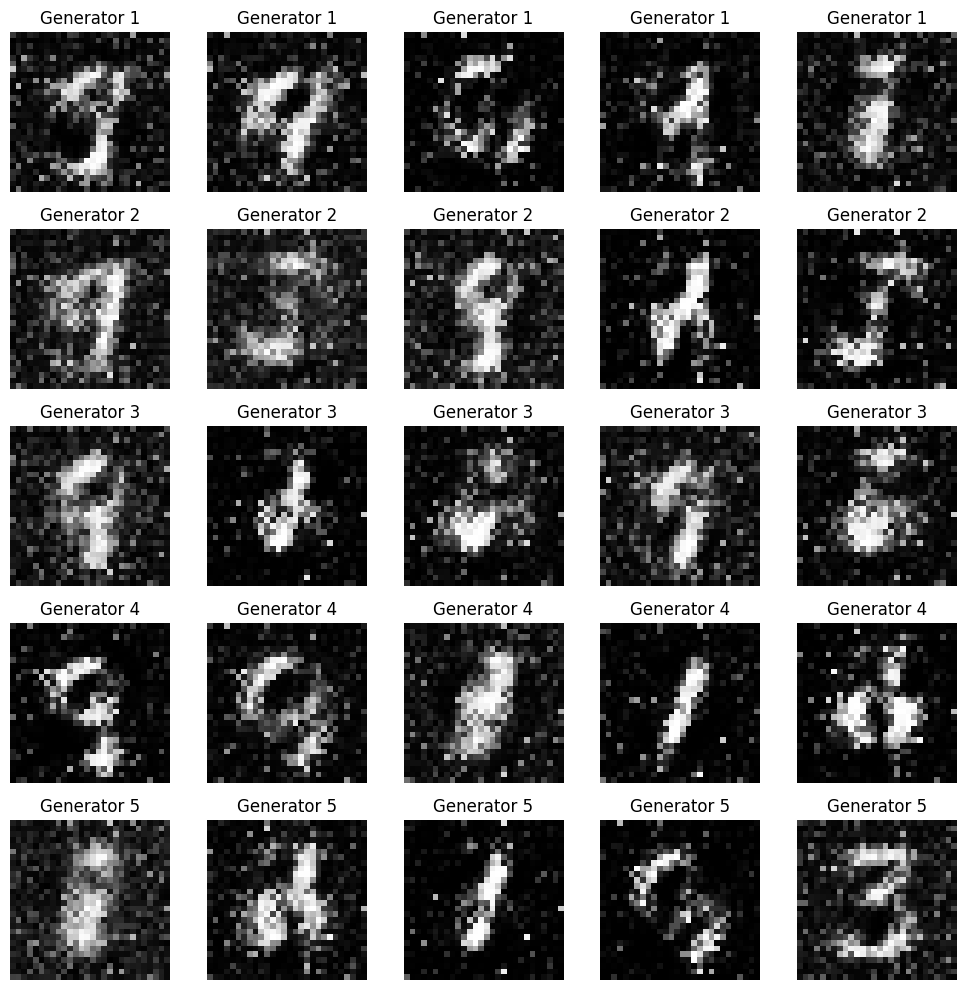

Epoch [6/100], Batch [0/188], D Loss: 0.5658, C Loss: 8.0822, G Loss: -5.5314, C Acc: 19.06%
Epoch [6/100], Batch [100/188], D Loss: 0.9241, C Loss: 8.1102, G Loss: -6.3308, C Acc: 19.06%
Epoch [7/100], Batch [0/188], D Loss: 0.8868, C Loss: 8.0638, G Loss: -5.9228, C Acc: 20.62%
Epoch [7/100], Batch [100/188], D Loss: 0.7789, C Loss: 8.0565, G Loss: -5.7864, C Acc: 19.69%
Epoch [8/100], Batch [0/188], D Loss: 0.7951, C Loss: 8.1265, G Loss: -6.0011, C Acc: 20.94%
Epoch [8/100], Batch [100/188], D Loss: 0.8391, C Loss: 8.0639, G Loss: -6.0237, C Acc: 21.88%
Epoch [9/100], Batch [0/188], D Loss: 0.6598, C Loss: 8.0622, G Loss: -5.9180, C Acc: 19.38%
Epoch [9/100], Batch [100/188], D Loss: 0.8000, C Loss: 8.0264, G Loss: -6.4523, C Acc: 18.75%
Epoch [10/100], Batch [0/188], D Loss: 0.9291, C Loss: 8.0550, G Loss: -6.6820, C Acc: 20.00%
Epoch [10/100], Batch [100/188], D Loss: 1.0408, C Loss: 8.0804, G Loss: -7.1559, C Acc: 19.06%
Generating samples at epoch 10


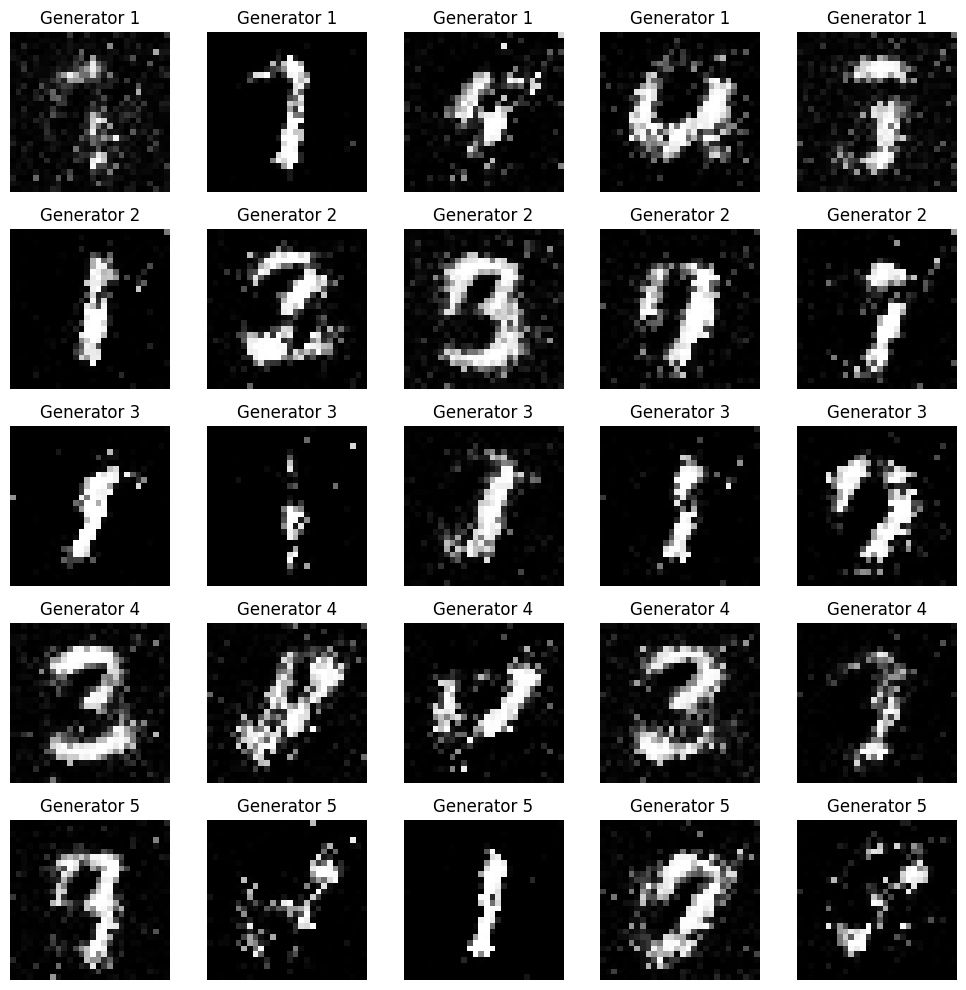

Epoch [11/100], Batch [0/188], D Loss: 0.8210, C Loss: 8.0652, G Loss: -6.4973, C Acc: 20.62%
Epoch [11/100], Batch [100/188], D Loss: 1.0711, C Loss: 8.0491, G Loss: -5.0923, C Acc: 19.38%
Epoch [12/100], Batch [0/188], D Loss: 1.0053, C Loss: 8.0435, G Loss: -6.5584, C Acc: 20.62%
Epoch [12/100], Batch [100/188], D Loss: 0.8276, C Loss: 8.0670, G Loss: -6.3687, C Acc: 19.06%
Epoch [13/100], Batch [0/188], D Loss: 0.7636, C Loss: 8.0539, G Loss: -6.6702, C Acc: 18.44%
Epoch [13/100], Batch [100/188], D Loss: 0.9314, C Loss: 8.0516, G Loss: -6.4536, C Acc: 19.38%
Epoch [14/100], Batch [0/188], D Loss: 1.0363, C Loss: 8.0263, G Loss: -7.0182, C Acc: 21.88%
Epoch [14/100], Batch [100/188], D Loss: 0.8798, C Loss: 8.0705, G Loss: -6.8083, C Acc: 20.31%
Epoch [15/100], Batch [0/188], D Loss: 1.1404, C Loss: 8.0676, G Loss: -7.1061, C Acc: 18.75%
Epoch [15/100], Batch [100/188], D Loss: 0.9809, C Loss: 8.0535, G Loss: -6.5116, C Acc: 20.62%
Generating samples at epoch 15


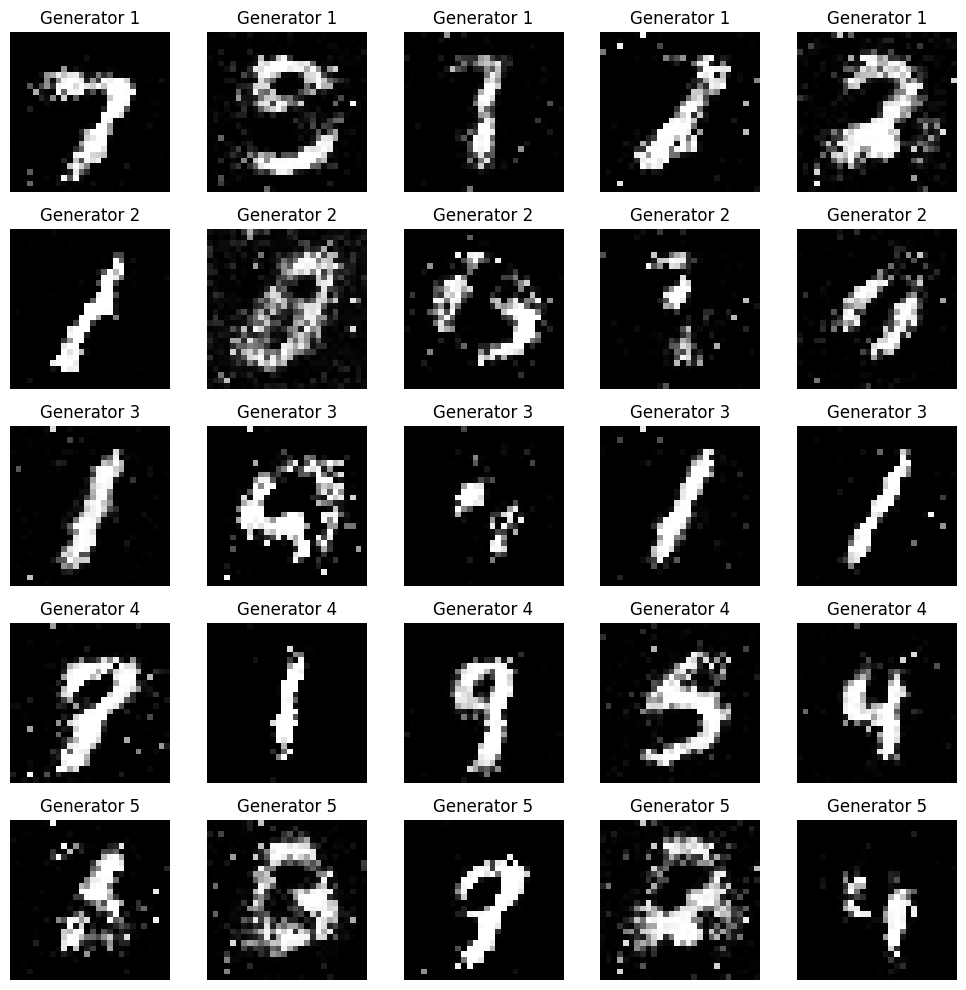

Epoch [16/100], Batch [0/188], D Loss: 1.0687, C Loss: 8.0682, G Loss: -6.1008, C Acc: 22.19%
Epoch [16/100], Batch [100/188], D Loss: 1.2880, C Loss: 8.0501, G Loss: -6.2374, C Acc: 21.88%
Epoch [17/100], Batch [0/188], D Loss: 0.8892, C Loss: 8.0340, G Loss: -6.8308, C Acc: 21.25%
Epoch [17/100], Batch [100/188], D Loss: 0.9761, C Loss: 8.0764, G Loss: -6.2064, C Acc: 15.94%
Epoch [18/100], Batch [0/188], D Loss: 1.0395, C Loss: 8.0371, G Loss: -6.6626, C Acc: 23.12%
Epoch [18/100], Batch [100/188], D Loss: 0.9644, C Loss: 8.0348, G Loss: -6.7452, C Acc: 22.81%
Epoch [19/100], Batch [0/188], D Loss: 1.0706, C Loss: 8.0516, G Loss: -6.5292, C Acc: 19.38%
Epoch [19/100], Batch [100/188], D Loss: 1.0792, C Loss: 8.0781, G Loss: -6.7687, C Acc: 16.25%
Epoch [20/100], Batch [0/188], D Loss: 1.1625, C Loss: 8.0447, G Loss: -6.7973, C Acc: 22.19%
Epoch [20/100], Batch [100/188], D Loss: 1.1203, C Loss: 8.0639, G Loss: -6.7612, C Acc: 16.88%
Generating samples at epoch 20


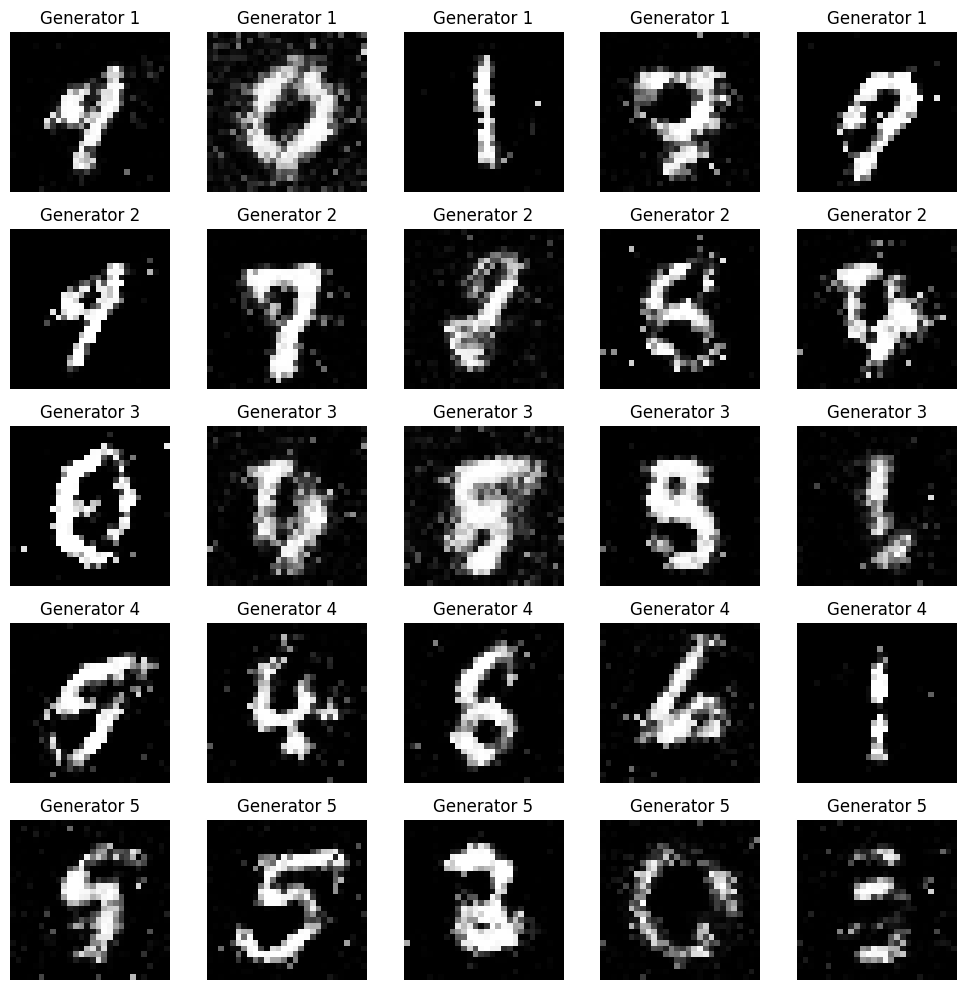

Epoch [21/100], Batch [0/188], D Loss: 1.1223, C Loss: 8.0505, G Loss: -6.9765, C Acc: 17.81%
Epoch [21/100], Batch [100/188], D Loss: 1.2089, C Loss: 8.0594, G Loss: -7.1469, C Acc: 18.75%
Epoch [22/100], Batch [0/188], D Loss: 1.1903, C Loss: 8.0569, G Loss: -6.6240, C Acc: 23.12%
Epoch [22/100], Batch [100/188], D Loss: 1.0680, C Loss: 8.0410, G Loss: -6.7662, C Acc: 24.38%
Epoch [23/100], Batch [0/188], D Loss: 1.1174, C Loss: 8.0383, G Loss: -6.9585, C Acc: 20.31%
Epoch [23/100], Batch [100/188], D Loss: 1.0893, C Loss: 8.0662, G Loss: -6.8420, C Acc: 16.88%
Epoch [24/100], Batch [0/188], D Loss: 1.1752, C Loss: 8.0451, G Loss: -6.8797, C Acc: 21.56%
Epoch [24/100], Batch [100/188], D Loss: 1.1079, C Loss: 8.0575, G Loss: -6.5289, C Acc: 21.56%
Epoch [25/100], Batch [0/188], D Loss: 1.1867, C Loss: 8.0610, G Loss: -7.1301, C Acc: 17.81%
Epoch [25/100], Batch [100/188], D Loss: 1.1216, C Loss: 8.0529, G Loss: -6.9939, C Acc: 20.94%
Generating samples at epoch 25


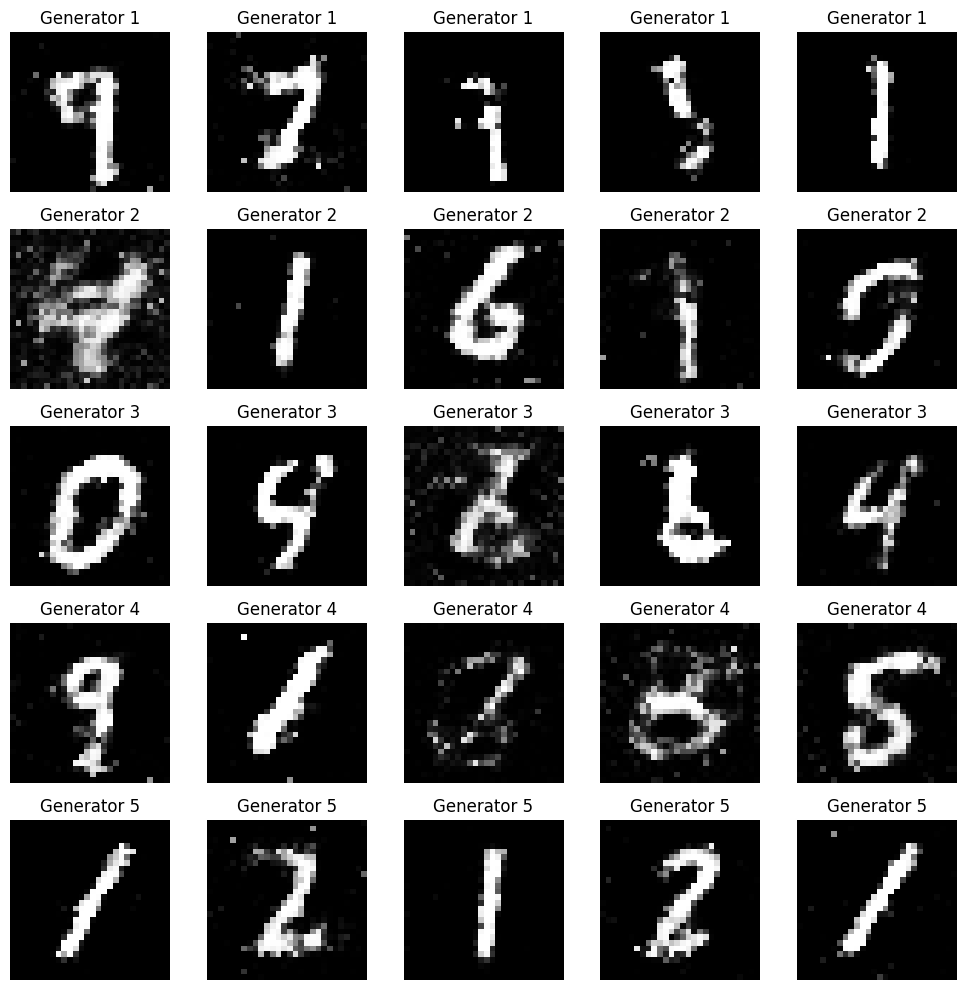

Epoch [26/100], Batch [0/188], D Loss: 1.1075, C Loss: 8.0338, G Loss: -6.7195, C Acc: 23.44%
Epoch [26/100], Batch [100/188], D Loss: 1.1918, C Loss: 8.0351, G Loss: -6.9175, C Acc: 20.00%
Epoch [27/100], Batch [0/188], D Loss: 1.2101, C Loss: 8.0507, G Loss: -7.0741, C Acc: 20.94%
Epoch [27/100], Batch [100/188], D Loss: 1.1656, C Loss: 8.0404, G Loss: -7.1896, C Acc: 22.50%
Epoch [28/100], Batch [0/188], D Loss: 1.2086, C Loss: 8.0289, G Loss: -6.6582, C Acc: 24.38%
Epoch [28/100], Batch [100/188], D Loss: 1.0766, C Loss: 8.0485, G Loss: -6.9972, C Acc: 17.81%
Epoch [29/100], Batch [0/188], D Loss: 1.1976, C Loss: 8.0429, G Loss: -7.0249, C Acc: 21.88%
Epoch [29/100], Batch [100/188], D Loss: 1.1892, C Loss: 8.0128, G Loss: -6.9456, C Acc: 22.50%
Epoch [30/100], Batch [0/188], D Loss: 1.1990, C Loss: 8.0470, G Loss: -7.0803, C Acc: 20.62%
Epoch [30/100], Batch [100/188], D Loss: 1.2015, C Loss: 8.0447, G Loss: -7.0031, C Acc: 20.31%
Generating samples at epoch 30


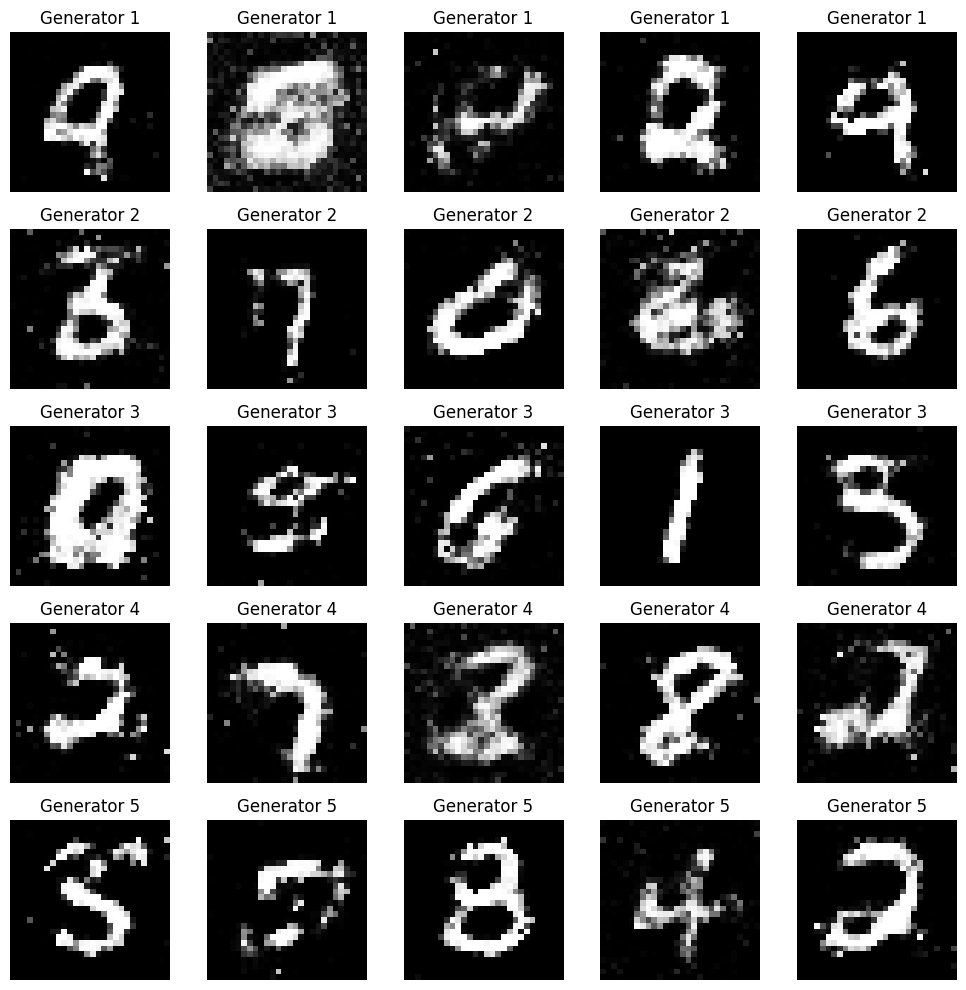

Epoch [31/100], Batch [0/188], D Loss: 1.2035, C Loss: 8.0624, G Loss: -6.9885, C Acc: 20.00%
Epoch [31/100], Batch [100/188], D Loss: 1.2328, C Loss: 8.0485, G Loss: -7.1316, C Acc: 20.31%
Epoch [32/100], Batch [0/188], D Loss: 1.2995, C Loss: 8.0381, G Loss: -6.8223, C Acc: 17.50%
Epoch [32/100], Batch [100/188], D Loss: 1.2619, C Loss: 8.0508, G Loss: -7.1178, C Acc: 21.56%
Epoch [33/100], Batch [0/188], D Loss: 1.2388, C Loss: 8.0592, G Loss: -6.9756, C Acc: 19.69%
Epoch [33/100], Batch [100/188], D Loss: 1.2394, C Loss: 8.0318, G Loss: -7.1164, C Acc: 23.12%
Epoch [34/100], Batch [0/188], D Loss: 1.2617, C Loss: 8.0390, G Loss: -7.1119, C Acc: 20.94%
Epoch [34/100], Batch [100/188], D Loss: 1.2803, C Loss: 8.0575, G Loss: -7.0768, C Acc: 19.38%
Epoch [35/100], Batch [0/188], D Loss: 1.2241, C Loss: 8.0494, G Loss: -6.9629, C Acc: 18.75%
Epoch [35/100], Batch [100/188], D Loss: 1.2713, C Loss: 8.0565, G Loss: -6.9459, C Acc: 17.81%
Generating samples at epoch 35


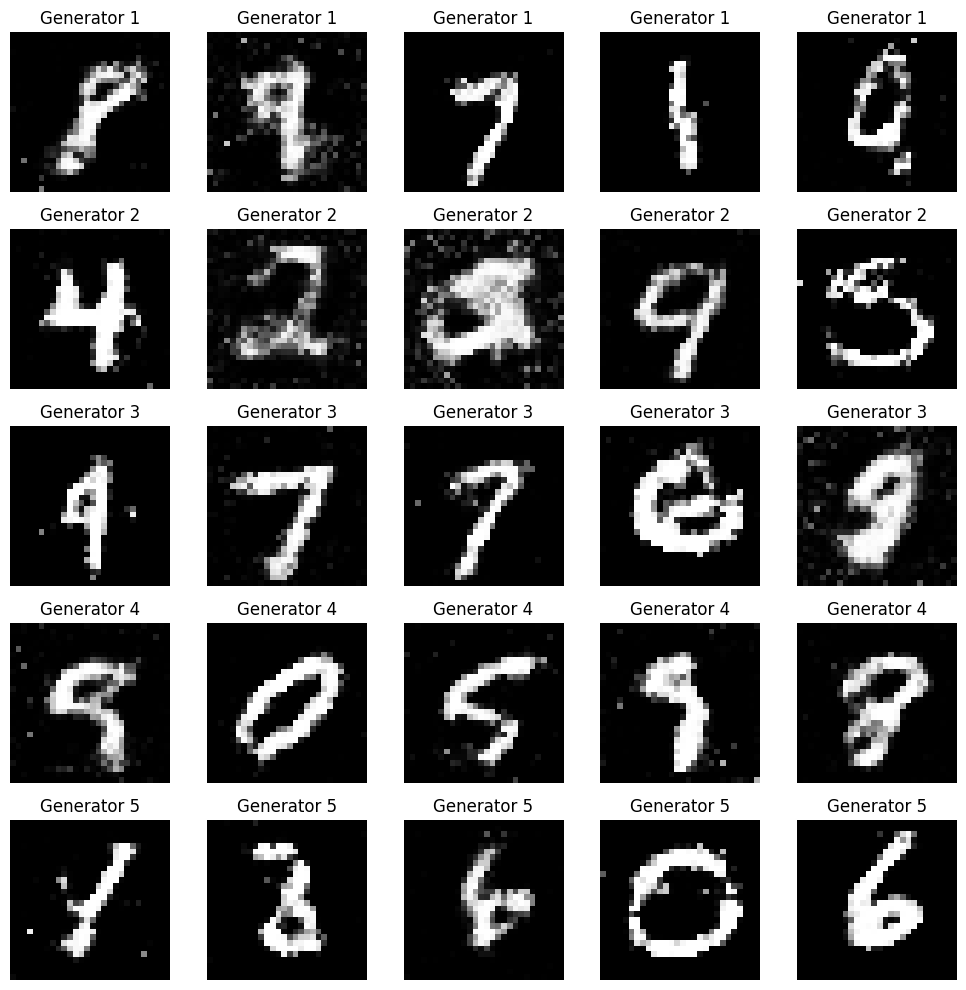

Epoch [36/100], Batch [0/188], D Loss: 1.3192, C Loss: 8.0475, G Loss: -7.1035, C Acc: 18.75%
Epoch [36/100], Batch [100/188], D Loss: 1.4450, C Loss: 8.0581, G Loss: -7.3952, C Acc: 19.38%
Epoch [37/100], Batch [0/188], D Loss: 1.2998, C Loss: 8.0473, G Loss: -7.3125, C Acc: 20.94%
Epoch [37/100], Batch [100/188], D Loss: 1.2494, C Loss: 8.0134, G Loss: -6.9986, C Acc: 22.19%
Epoch [38/100], Batch [0/188], D Loss: 1.2816, C Loss: 8.0653, G Loss: -7.0161, C Acc: 18.75%
Epoch [38/100], Batch [100/188], D Loss: 1.2371, C Loss: 8.0818, G Loss: -7.2108, C Acc: 17.19%
Epoch [39/100], Batch [0/188], D Loss: 1.2292, C Loss: 8.0413, G Loss: -7.1736, C Acc: 20.31%
Epoch [39/100], Batch [100/188], D Loss: 1.2611, C Loss: 8.0645, G Loss: -7.1337, C Acc: 16.88%
Epoch [40/100], Batch [0/188], D Loss: 1.2144, C Loss: 8.0412, G Loss: -7.0455, C Acc: 21.25%
Epoch [40/100], Batch [100/188], D Loss: 1.2347, C Loss: 8.0503, G Loss: -7.0945, C Acc: 17.50%
Generating samples at epoch 40


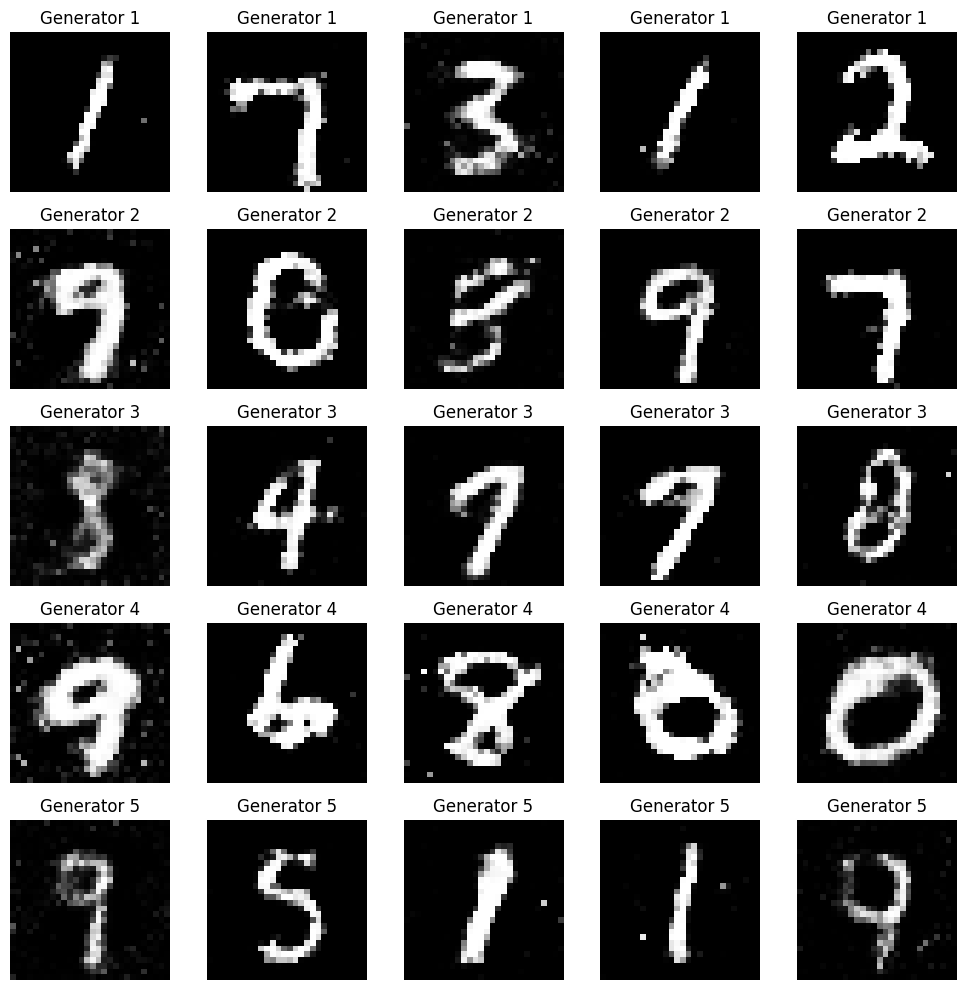

Epoch [41/100], Batch [0/188], D Loss: 1.2567, C Loss: 8.0386, G Loss: -7.2364, C Acc: 18.44%
Epoch [41/100], Batch [100/188], D Loss: 1.3139, C Loss: 8.0557, G Loss: -7.2488, C Acc: 16.56%
Epoch [42/100], Batch [0/188], D Loss: 1.2879, C Loss: 8.0597, G Loss: -7.1250, C Acc: 19.06%
Epoch [42/100], Batch [100/188], D Loss: 1.2845, C Loss: 8.0384, G Loss: -7.1556, C Acc: 18.44%
Epoch [43/100], Batch [0/188], D Loss: 1.2838, C Loss: 8.0468, G Loss: -7.2022, C Acc: 19.06%
Epoch [43/100], Batch [100/188], D Loss: 1.2652, C Loss: 8.0380, G Loss: -7.1056, C Acc: 20.31%
Epoch [44/100], Batch [0/188], D Loss: 1.3206, C Loss: 8.0505, G Loss: -7.3574, C Acc: 21.25%
Epoch [44/100], Batch [100/188], D Loss: 1.2916, C Loss: 8.0473, G Loss: -7.2048, C Acc: 20.31%
Epoch [45/100], Batch [0/188], D Loss: 1.2830, C Loss: 8.0739, G Loss: -7.1893, C Acc: 19.38%
Epoch [45/100], Batch [100/188], D Loss: 1.2688, C Loss: 8.0490, G Loss: -7.0298, C Acc: 20.94%
Generating samples at epoch 45


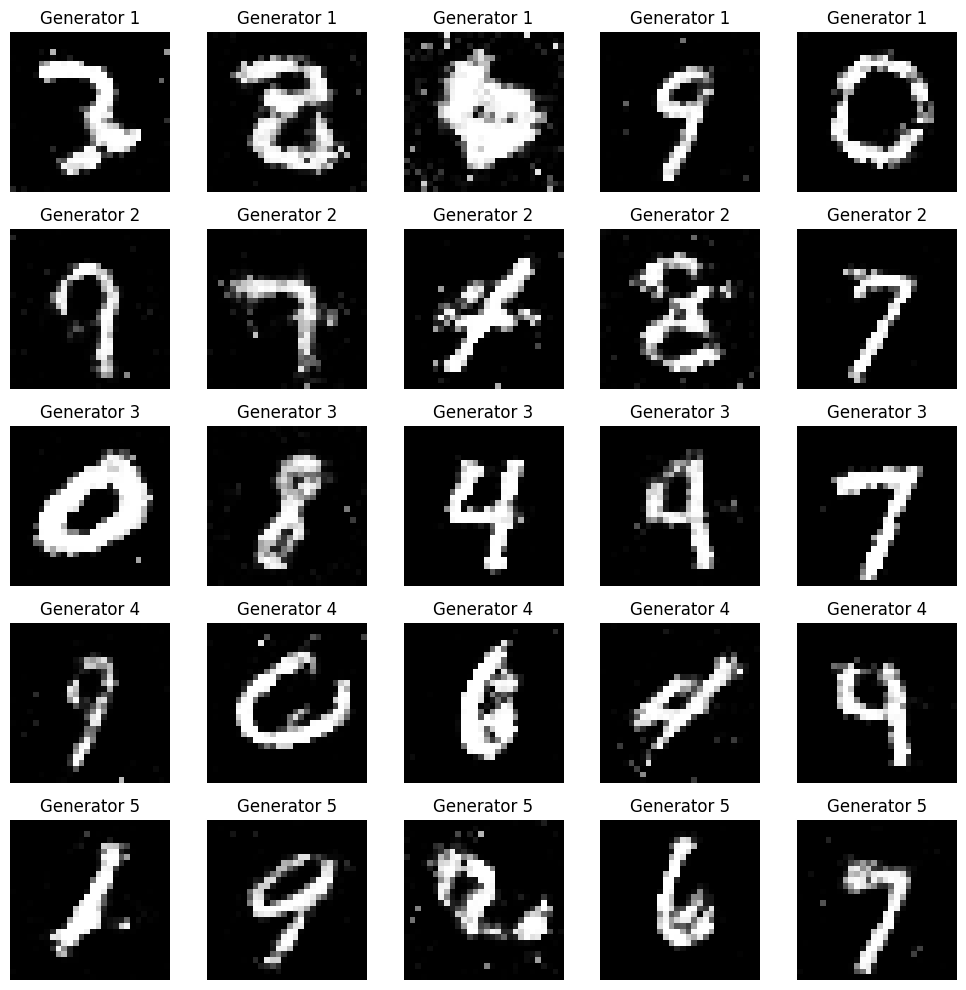

Epoch [46/100], Batch [0/188], D Loss: 1.2680, C Loss: 8.0494, G Loss: -7.2391, C Acc: 23.44%
Epoch [46/100], Batch [100/188], D Loss: 1.3095, C Loss: 8.0312, G Loss: -7.1780, C Acc: 22.19%
Epoch [47/100], Batch [0/188], D Loss: 1.3151, C Loss: 8.0489, G Loss: -7.2198, C Acc: 22.19%
Epoch [47/100], Batch [100/188], D Loss: 1.2960, C Loss: 8.0445, G Loss: -7.1959, C Acc: 19.69%
Epoch [48/100], Batch [0/188], D Loss: 1.3015, C Loss: 8.0456, G Loss: -7.1002, C Acc: 18.12%
Epoch [48/100], Batch [100/188], D Loss: 1.3365, C Loss: 8.0549, G Loss: -7.0603, C Acc: 21.56%
Epoch [49/100], Batch [0/188], D Loss: 1.2880, C Loss: 8.0354, G Loss: -7.0494, C Acc: 25.62%
Epoch [49/100], Batch [100/188], D Loss: 1.3038, C Loss: 8.0500, G Loss: -7.2127, C Acc: 21.25%
Epoch [50/100], Batch [0/188], D Loss: 1.3221, C Loss: 8.0596, G Loss: -7.1648, C Acc: 19.38%
Epoch [50/100], Batch [100/188], D Loss: 1.2627, C Loss: 8.0679, G Loss: -7.2009, C Acc: 21.88%
Generating samples at epoch 50


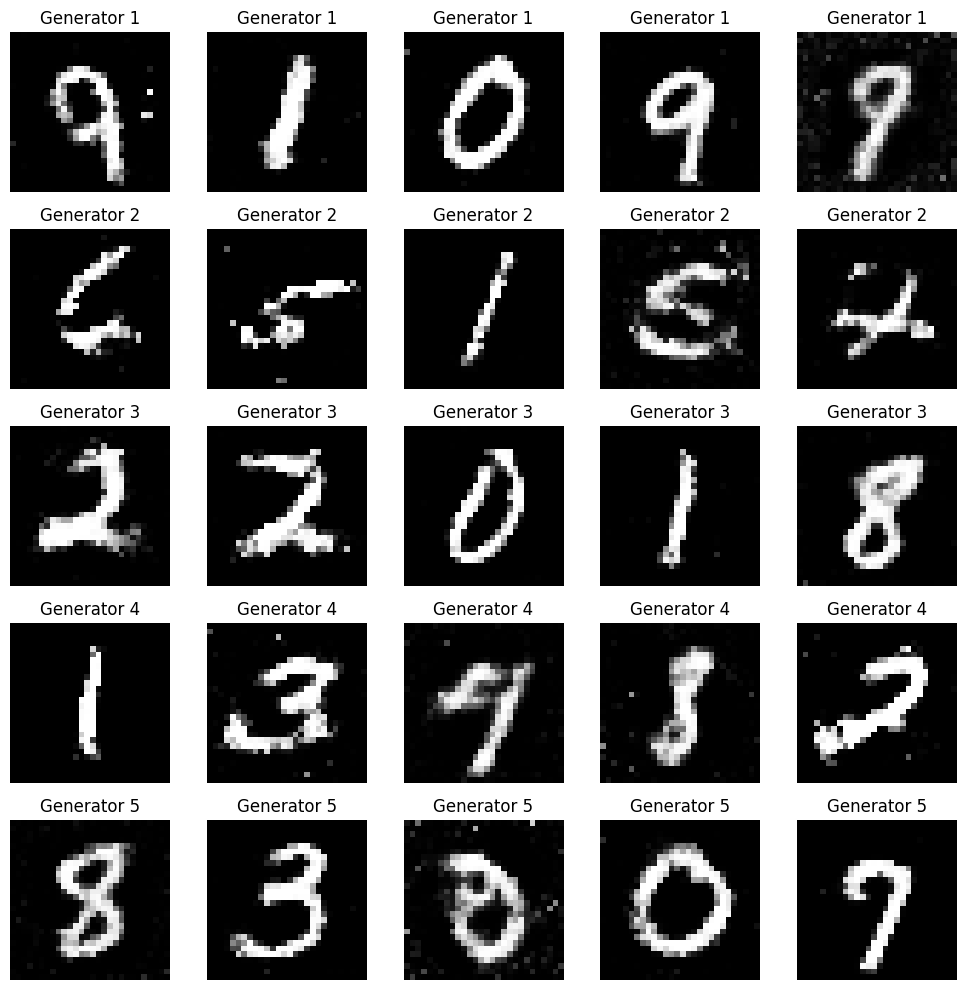

Epoch [51/100], Batch [0/188], D Loss: 1.3409, C Loss: 8.0438, G Loss: -7.2045, C Acc: 20.62%
Epoch [51/100], Batch [100/188], D Loss: 1.3151, C Loss: 8.0540, G Loss: -7.2070, C Acc: 18.75%
Epoch [52/100], Batch [0/188], D Loss: 1.3282, C Loss: 8.0439, G Loss: -6.9537, C Acc: 21.25%
Epoch [52/100], Batch [100/188], D Loss: 1.3144, C Loss: 8.0419, G Loss: -7.2709, C Acc: 19.38%
Epoch [53/100], Batch [0/188], D Loss: 1.2595, C Loss: 8.0517, G Loss: -7.2227, C Acc: 17.19%
Epoch [53/100], Batch [100/188], D Loss: 1.3067, C Loss: 8.0527, G Loss: -7.2729, C Acc: 21.88%
Epoch [54/100], Batch [0/188], D Loss: 1.4076, C Loss: 8.0476, G Loss: -6.9299, C Acc: 20.62%
Epoch [54/100], Batch [100/188], D Loss: 1.2875, C Loss: 8.0532, G Loss: -7.0976, C Acc: 18.44%
Epoch [55/100], Batch [0/188], D Loss: 1.3361, C Loss: 8.0466, G Loss: -7.1920, C Acc: 21.88%
Epoch [55/100], Batch [100/188], D Loss: 1.2962, C Loss: 8.0427, G Loss: -7.3337, C Acc: 16.56%
Generating samples at epoch 55


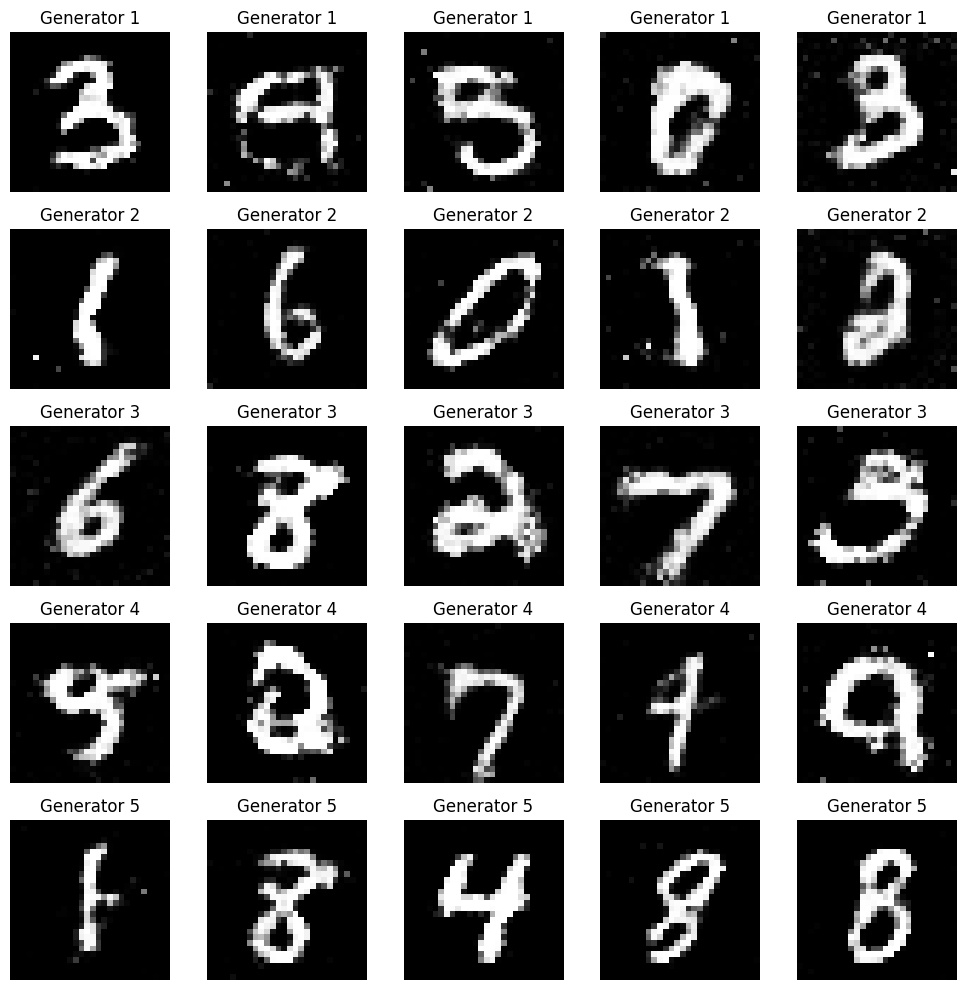

Epoch [56/100], Batch [0/188], D Loss: 1.3001, C Loss: 8.0584, G Loss: -7.2718, C Acc: 20.62%
Epoch [56/100], Batch [100/188], D Loss: 1.3388, C Loss: 8.0671, G Loss: -7.1276, C Acc: 15.31%
Epoch [57/100], Batch [0/188], D Loss: 1.3568, C Loss: 8.0633, G Loss: -7.2612, C Acc: 19.06%
Epoch [57/100], Batch [100/188], D Loss: 1.3180, C Loss: 8.0522, G Loss: -7.2034, C Acc: 16.56%
Epoch [58/100], Batch [0/188], D Loss: 1.3276, C Loss: 8.0460, G Loss: -7.0579, C Acc: 19.38%
Epoch [58/100], Batch [100/188], D Loss: 1.3293, C Loss: 8.0513, G Loss: -7.2151, C Acc: 22.50%
Epoch [59/100], Batch [0/188], D Loss: 1.2939, C Loss: 8.0515, G Loss: -7.1967, C Acc: 18.12%
Epoch [59/100], Batch [100/188], D Loss: 1.3321, C Loss: 8.0544, G Loss: -7.1866, C Acc: 17.50%
Epoch [60/100], Batch [0/188], D Loss: 1.2903, C Loss: 8.0717, G Loss: -7.2492, C Acc: 17.81%
Epoch [60/100], Batch [100/188], D Loss: 1.3052, C Loss: 8.0469, G Loss: -7.1984, C Acc: 16.56%
Generating samples at epoch 60


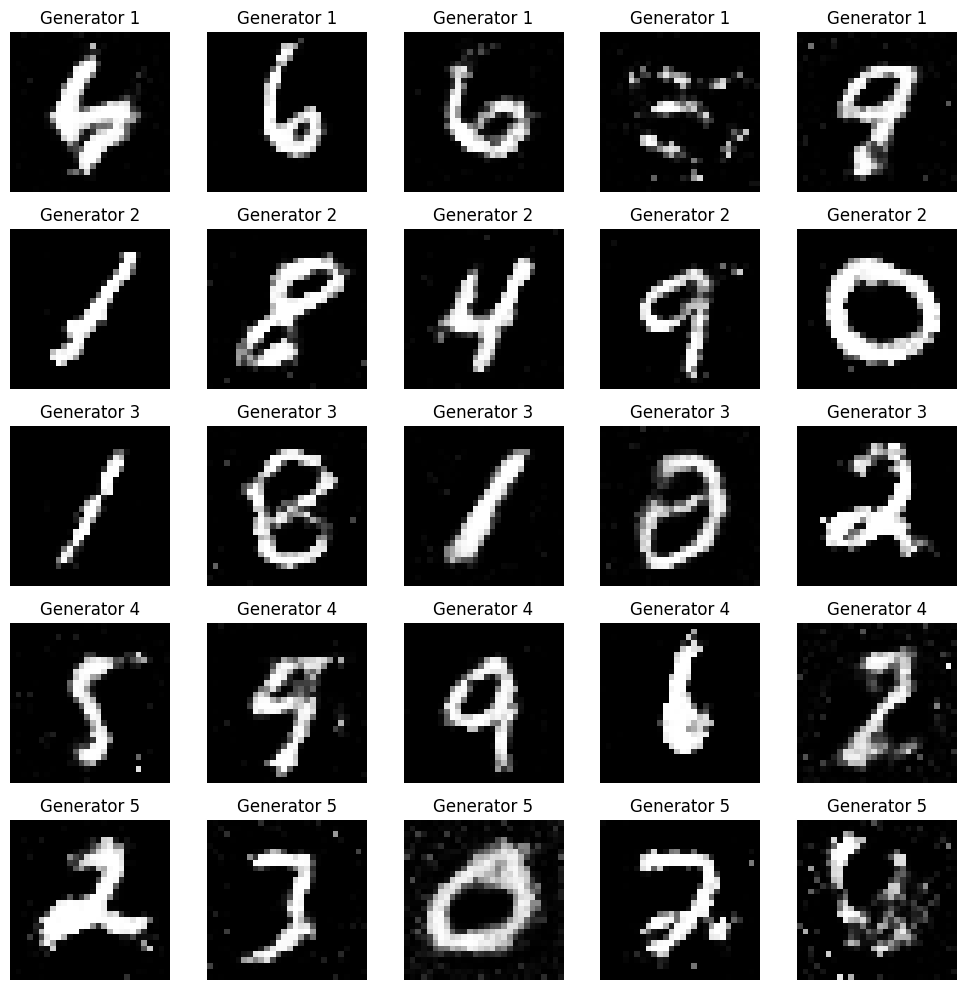

Epoch [61/100], Batch [0/188], D Loss: 1.3547, C Loss: 8.0517, G Loss: -7.2021, C Acc: 21.88%
Epoch [61/100], Batch [100/188], D Loss: 1.2954, C Loss: 8.0606, G Loss: -7.2298, C Acc: 15.31%
Epoch [62/100], Batch [0/188], D Loss: 1.3246, C Loss: 8.0494, G Loss: -7.2133, C Acc: 19.06%
Epoch [62/100], Batch [100/188], D Loss: 1.3112, C Loss: 8.0565, G Loss: -7.2217, C Acc: 19.69%
Epoch [63/100], Batch [0/188], D Loss: 1.3633, C Loss: 8.0520, G Loss: -7.2712, C Acc: 20.31%
Epoch [63/100], Batch [100/188], D Loss: 1.3987, C Loss: 8.0497, G Loss: -7.0602, C Acc: 20.31%
Epoch [64/100], Batch [0/188], D Loss: 1.3472, C Loss: 8.0515, G Loss: -7.2895, C Acc: 18.44%
Epoch [64/100], Batch [100/188], D Loss: 1.3459, C Loss: 8.0464, G Loss: -7.2328, C Acc: 20.62%
Epoch [65/100], Batch [0/188], D Loss: 1.3642, C Loss: 8.0557, G Loss: -7.2631, C Acc: 19.69%
Epoch [65/100], Batch [100/188], D Loss: 1.3255, C Loss: 8.0631, G Loss: -7.3158, C Acc: 16.25%
Generating samples at epoch 65


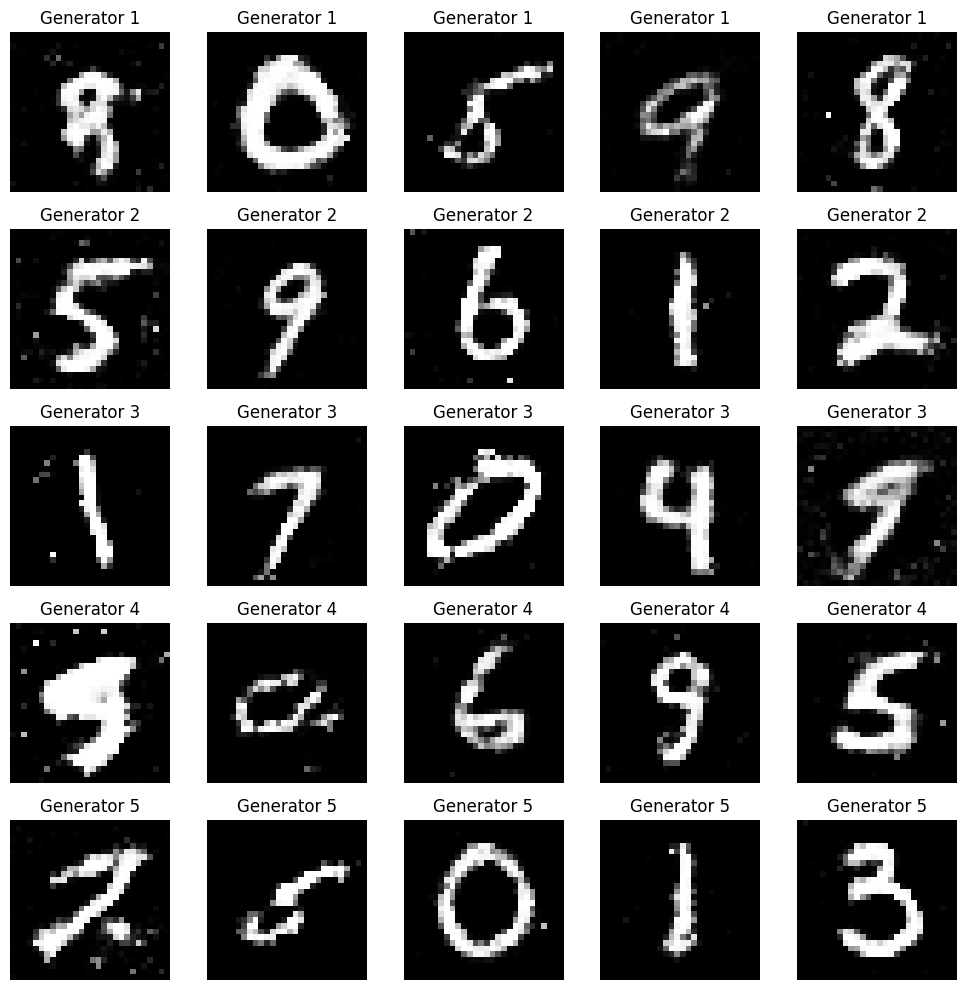

Epoch [66/100], Batch [0/188], D Loss: 1.3131, C Loss: 8.0578, G Loss: -7.2032, C Acc: 18.12%
Epoch [66/100], Batch [100/188], D Loss: 1.3329, C Loss: 8.0528, G Loss: -7.2194, C Acc: 15.62%
Epoch [67/100], Batch [0/188], D Loss: 1.3313, C Loss: 8.0444, G Loss: -7.3160, C Acc: 24.69%
Epoch [67/100], Batch [100/188], D Loss: 1.3204, C Loss: 8.0438, G Loss: -7.1629, C Acc: 19.69%
Epoch [68/100], Batch [0/188], D Loss: 1.3470, C Loss: 8.0496, G Loss: -7.1990, C Acc: 18.75%
Epoch [68/100], Batch [100/188], D Loss: 1.3366, C Loss: 8.0262, G Loss: -7.1594, C Acc: 23.44%
Epoch [69/100], Batch [0/188], D Loss: 1.3393, C Loss: 8.0681, G Loss: -7.2175, C Acc: 19.38%
Epoch [69/100], Batch [100/188], D Loss: 1.3479, C Loss: 8.0601, G Loss: -7.2898, C Acc: 16.25%
Epoch [70/100], Batch [0/188], D Loss: 1.3218, C Loss: 8.0273, G Loss: -7.2273, C Acc: 25.62%
Epoch [70/100], Batch [100/188], D Loss: 1.3231, C Loss: 8.0399, G Loss: -7.1968, C Acc: 21.25%
Generating samples at epoch 70


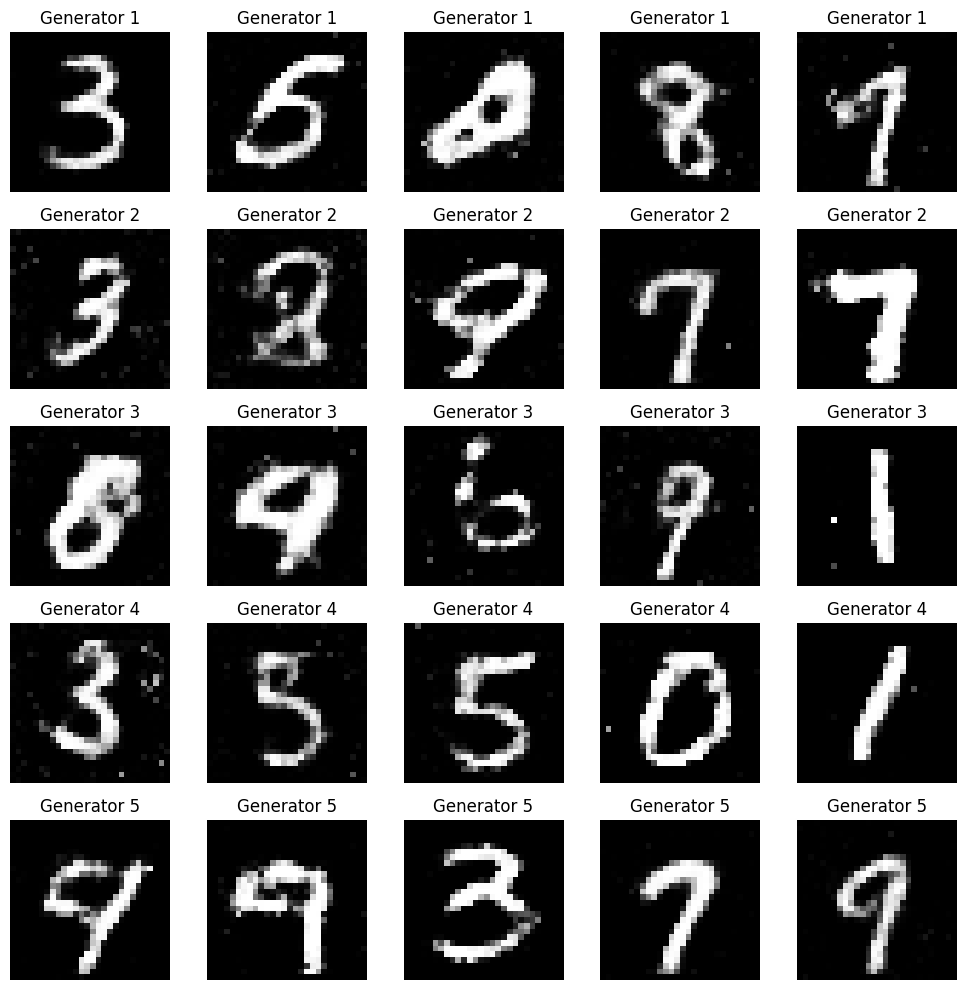

Epoch [71/100], Batch [0/188], D Loss: 1.3517, C Loss: 8.0392, G Loss: -7.2463, C Acc: 20.00%
Epoch [71/100], Batch [100/188], D Loss: 1.3111, C Loss: 8.0465, G Loss: -7.2290, C Acc: 19.06%
Epoch [72/100], Batch [0/188], D Loss: 1.3156, C Loss: 8.0486, G Loss: -7.2625, C Acc: 18.12%
Epoch [72/100], Batch [100/188], D Loss: 1.3558, C Loss: 8.0329, G Loss: -7.2878, C Acc: 24.06%
Epoch [73/100], Batch [0/188], D Loss: 1.3791, C Loss: 8.0489, G Loss: -7.2072, C Acc: 22.19%
Epoch [73/100], Batch [100/188], D Loss: 1.3377, C Loss: 8.0406, G Loss: -7.2504, C Acc: 20.31%
Epoch [74/100], Batch [0/188], D Loss: 1.3542, C Loss: 8.0468, G Loss: -7.0731, C Acc: 20.94%
Epoch [74/100], Batch [100/188], D Loss: 1.3448, C Loss: 8.0560, G Loss: -7.1719, C Acc: 19.38%
Epoch [75/100], Batch [0/188], D Loss: 1.3401, C Loss: 8.0269, G Loss: -7.2771, C Acc: 26.25%
Epoch [75/100], Batch [100/188], D Loss: 1.3298, C Loss: 8.0461, G Loss: -7.2557, C Acc: 21.88%
Generating samples at epoch 75


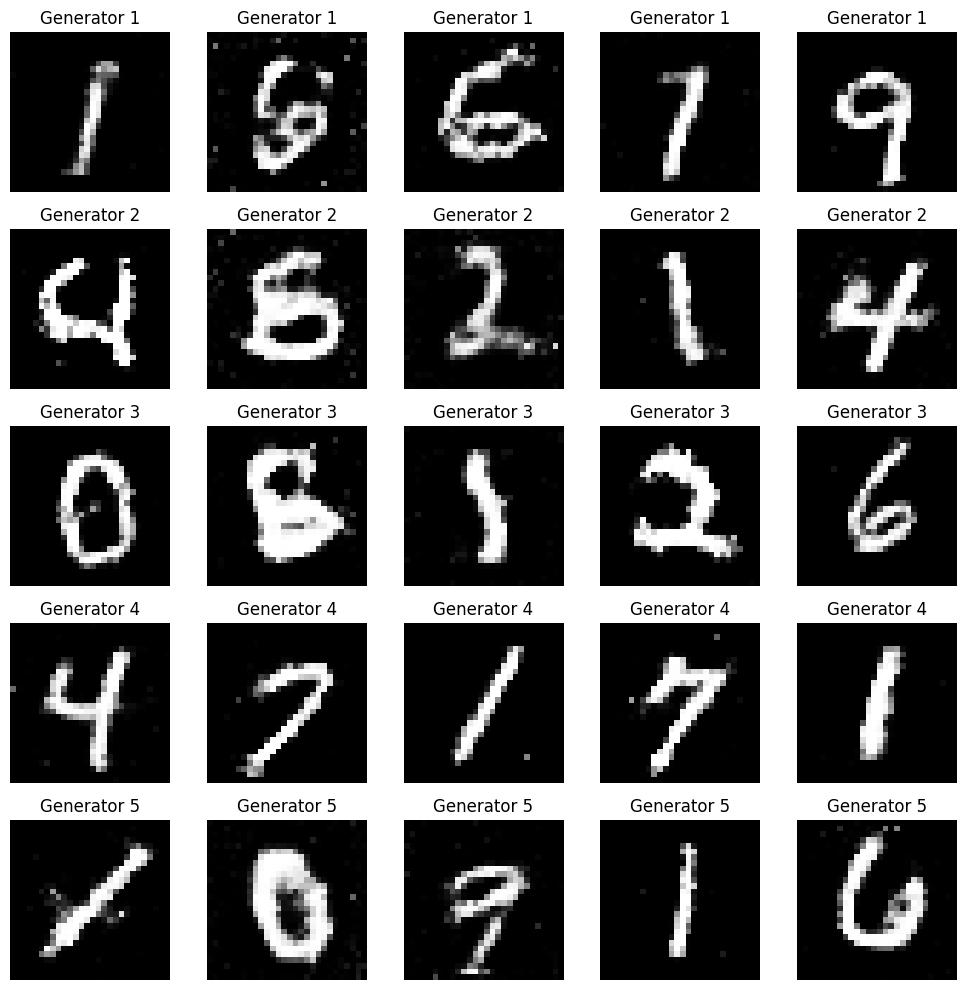

Epoch [76/100], Batch [0/188], D Loss: 1.3427, C Loss: 8.0465, G Loss: -7.2564, C Acc: 23.75%
Epoch [76/100], Batch [100/188], D Loss: 1.3577, C Loss: 8.0548, G Loss: -7.3156, C Acc: 18.75%
Epoch [77/100], Batch [0/188], D Loss: 1.3528, C Loss: 8.0551, G Loss: -7.2197, C Acc: 18.44%
Epoch [77/100], Batch [100/188], D Loss: 1.3113, C Loss: 8.0592, G Loss: -7.2725, C Acc: 18.12%
Epoch [78/100], Batch [0/188], D Loss: 1.3302, C Loss: 8.0622, G Loss: -7.2109, C Acc: 18.75%
Epoch [78/100], Batch [100/188], D Loss: 1.3422, C Loss: 8.0622, G Loss: -7.2550, C Acc: 17.19%
Epoch [79/100], Batch [0/188], D Loss: 1.3354, C Loss: 8.0413, G Loss: -7.2307, C Acc: 21.56%
Epoch [79/100], Batch [100/188], D Loss: 1.3438, C Loss: 8.0597, G Loss: -7.2638, C Acc: 20.00%
Epoch [80/100], Batch [0/188], D Loss: 1.3298, C Loss: 8.0526, G Loss: -7.3054, C Acc: 18.44%
Epoch [80/100], Batch [100/188], D Loss: 1.3331, C Loss: 8.0529, G Loss: -7.2761, C Acc: 17.81%
Generating samples at epoch 80


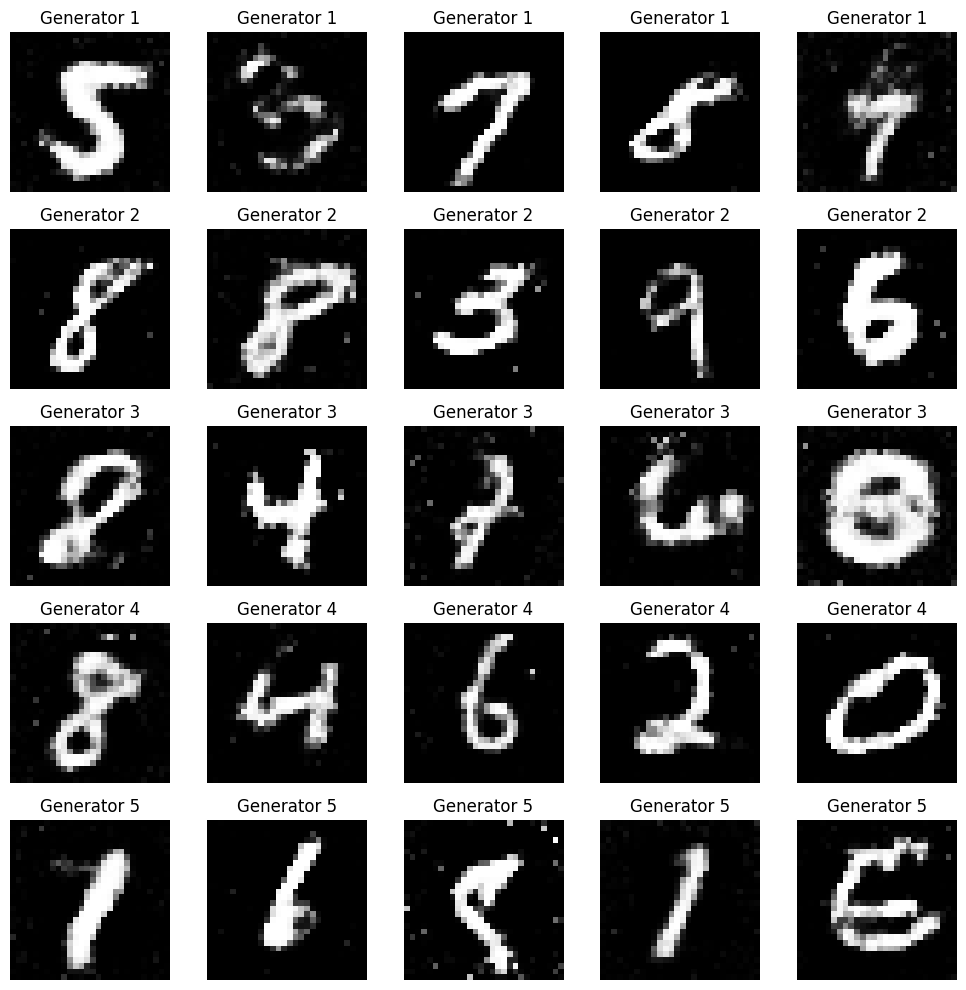

Epoch [81/100], Batch [0/188], D Loss: 1.3489, C Loss: 8.0396, G Loss: -7.3025, C Acc: 23.12%
Epoch [81/100], Batch [100/188], D Loss: 1.3631, C Loss: 8.0583, G Loss: -7.1685, C Acc: 17.19%
Epoch [82/100], Batch [0/188], D Loss: 1.3498, C Loss: 8.0661, G Loss: -7.3148, C Acc: 19.06%
Epoch [82/100], Batch [100/188], D Loss: 1.3270, C Loss: 8.0469, G Loss: -7.2535, C Acc: 19.69%
Epoch [83/100], Batch [0/188], D Loss: 1.3508, C Loss: 8.0483, G Loss: -7.2227, C Acc: 18.75%
Epoch [83/100], Batch [100/188], D Loss: 1.3453, C Loss: 8.0385, G Loss: -7.3152, C Acc: 21.88%
Epoch [84/100], Batch [0/188], D Loss: 1.3344, C Loss: 8.0394, G Loss: -7.2376, C Acc: 21.56%
Epoch [84/100], Batch [100/188], D Loss: 1.3422, C Loss: 8.0335, G Loss: -7.2112, C Acc: 22.81%
Epoch [85/100], Batch [0/188], D Loss: 1.2952, C Loss: 8.0478, G Loss: -7.3525, C Acc: 18.12%
Epoch [85/100], Batch [100/188], D Loss: 1.3347, C Loss: 8.0536, G Loss: -7.2830, C Acc: 21.56%
Generating samples at epoch 85


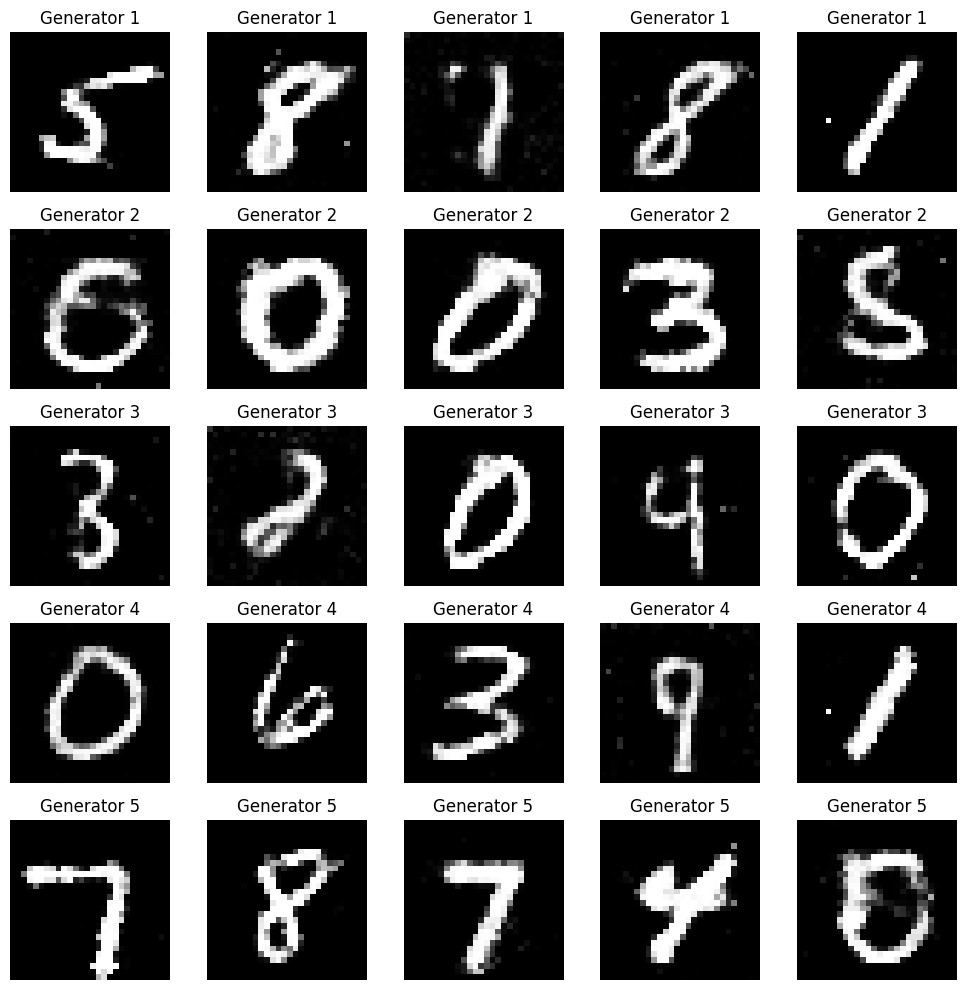

Epoch [86/100], Batch [0/188], D Loss: 1.3408, C Loss: 8.0478, G Loss: -7.3016, C Acc: 16.56%
Epoch [86/100], Batch [100/188], D Loss: 1.3393, C Loss: 8.0510, G Loss: -7.2020, C Acc: 19.06%
Epoch [87/100], Batch [0/188], D Loss: 1.3363, C Loss: 8.0559, G Loss: -7.2252, C Acc: 21.56%
Epoch [87/100], Batch [100/188], D Loss: 1.3488, C Loss: 8.0495, G Loss: -7.2632, C Acc: 23.12%
Epoch [88/100], Batch [0/188], D Loss: 1.3423, C Loss: 8.0619, G Loss: -7.2904, C Acc: 17.19%
Epoch [88/100], Batch [100/188], D Loss: 1.3279, C Loss: 8.0527, G Loss: -7.1805, C Acc: 18.12%
Epoch [89/100], Batch [0/188], D Loss: 1.3601, C Loss: 8.0374, G Loss: -7.3083, C Acc: 22.50%
Epoch [89/100], Batch [100/188], D Loss: 1.3332, C Loss: 8.0527, G Loss: -7.2269, C Acc: 22.81%
Epoch [90/100], Batch [0/188], D Loss: 1.3612, C Loss: 8.0466, G Loss: -7.2535, C Acc: 19.69%
Epoch [90/100], Batch [100/188], D Loss: 1.3184, C Loss: 8.0278, G Loss: -7.2331, C Acc: 24.69%
Generating samples at epoch 90


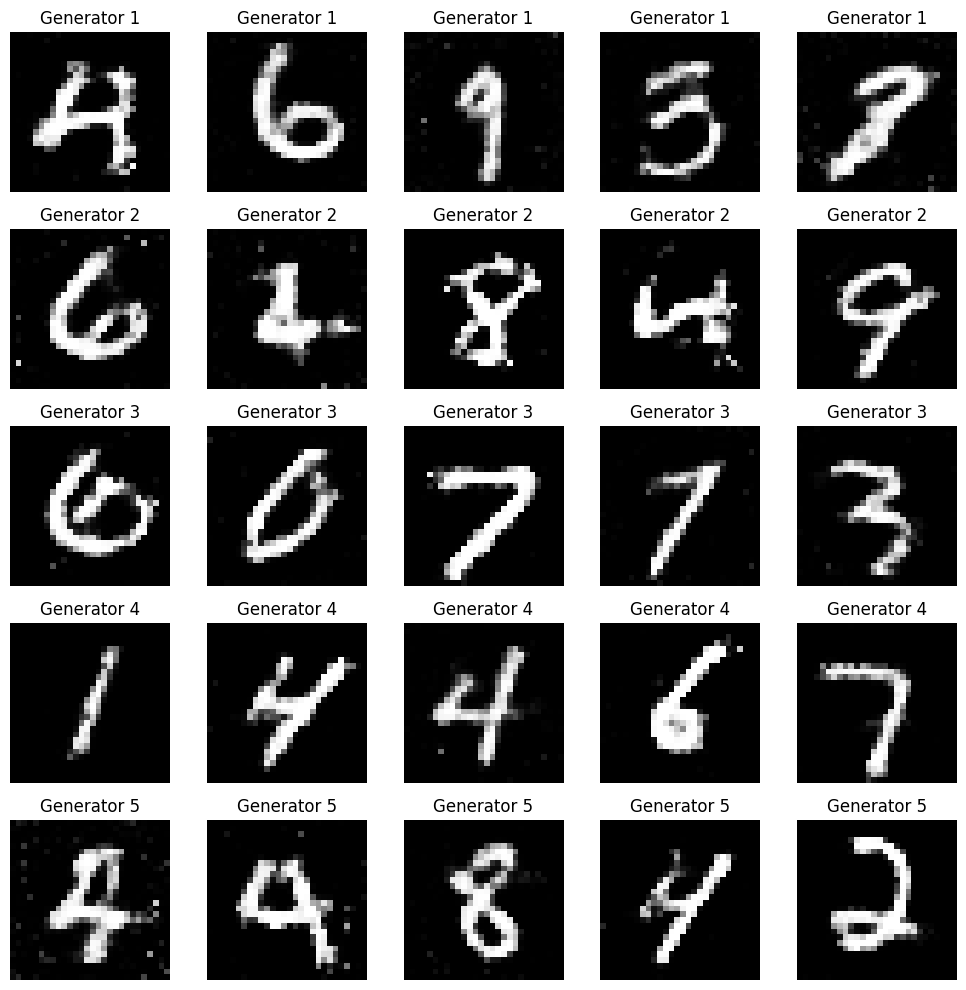

Epoch [91/100], Batch [0/188], D Loss: 1.3848, C Loss: 8.0366, G Loss: -7.1508, C Acc: 21.56%
Epoch [91/100], Batch [100/188], D Loss: 1.3427, C Loss: 8.0519, G Loss: -7.2096, C Acc: 23.44%
Epoch [92/100], Batch [0/188], D Loss: 1.3338, C Loss: 8.0511, G Loss: -7.3015, C Acc: 16.88%
Epoch [92/100], Batch [100/188], D Loss: 1.3142, C Loss: 8.0579, G Loss: -7.2823, C Acc: 16.25%
Epoch [93/100], Batch [0/188], D Loss: 1.3413, C Loss: 8.0461, G Loss: -7.2602, C Acc: 19.69%
Epoch [93/100], Batch [100/188], D Loss: 1.3559, C Loss: 8.0522, G Loss: -7.3507, C Acc: 20.31%
Epoch [94/100], Batch [0/188], D Loss: 1.3294, C Loss: 8.0401, G Loss: -7.2011, C Acc: 20.62%
Epoch [94/100], Batch [100/188], D Loss: 1.3403, C Loss: 8.0463, G Loss: -7.2356, C Acc: 20.94%
Epoch [95/100], Batch [0/188], D Loss: 1.3504, C Loss: 8.0469, G Loss: -7.3225, C Acc: 21.56%
Epoch [95/100], Batch [100/188], D Loss: 1.3806, C Loss: 8.0513, G Loss: -7.4097, C Acc: 20.94%
Generating samples at epoch 95


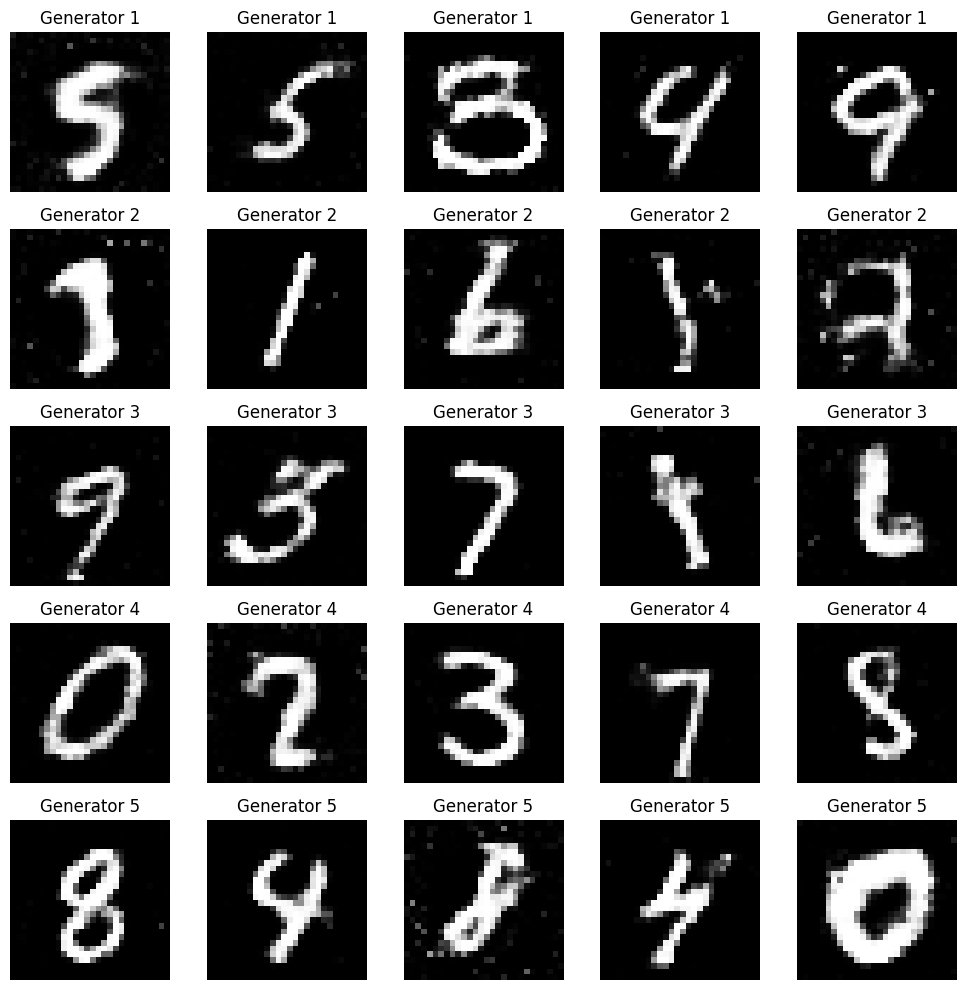

Epoch [96/100], Batch [0/188], D Loss: 1.3661, C Loss: 8.0568, G Loss: -7.2736, C Acc: 20.00%
Epoch [96/100], Batch [100/188], D Loss: 1.3820, C Loss: 8.0498, G Loss: -7.2581, C Acc: 19.69%
Epoch [97/100], Batch [0/188], D Loss: 1.3605, C Loss: 8.0461, G Loss: -7.2643, C Acc: 18.75%
Epoch [97/100], Batch [100/188], D Loss: 1.3512, C Loss: 8.0438, G Loss: -7.2965, C Acc: 22.81%
Epoch [98/100], Batch [0/188], D Loss: 1.3493, C Loss: 8.0480, G Loss: -7.1520, C Acc: 20.94%
Epoch [98/100], Batch [100/188], D Loss: 1.3503, C Loss: 8.0353, G Loss: -7.2364, C Acc: 27.19%
Epoch [99/100], Batch [0/188], D Loss: 1.3322, C Loss: 8.0546, G Loss: -7.2905, C Acc: 20.62%
Epoch [99/100], Batch [100/188], D Loss: 1.3357, C Loss: 8.0423, G Loss: -7.2435, C Acc: 22.50%
Epoch [100/100], Batch [0/188], D Loss: 1.3253, C Loss: 8.0516, G Loss: -7.2630, C Acc: 20.62%
Epoch [100/100], Batch [100/188], D Loss: 1.3598, C Loss: 8.0406, G Loss: -7.2046, C Acc: 19.06%
Generating samples at epoch 100


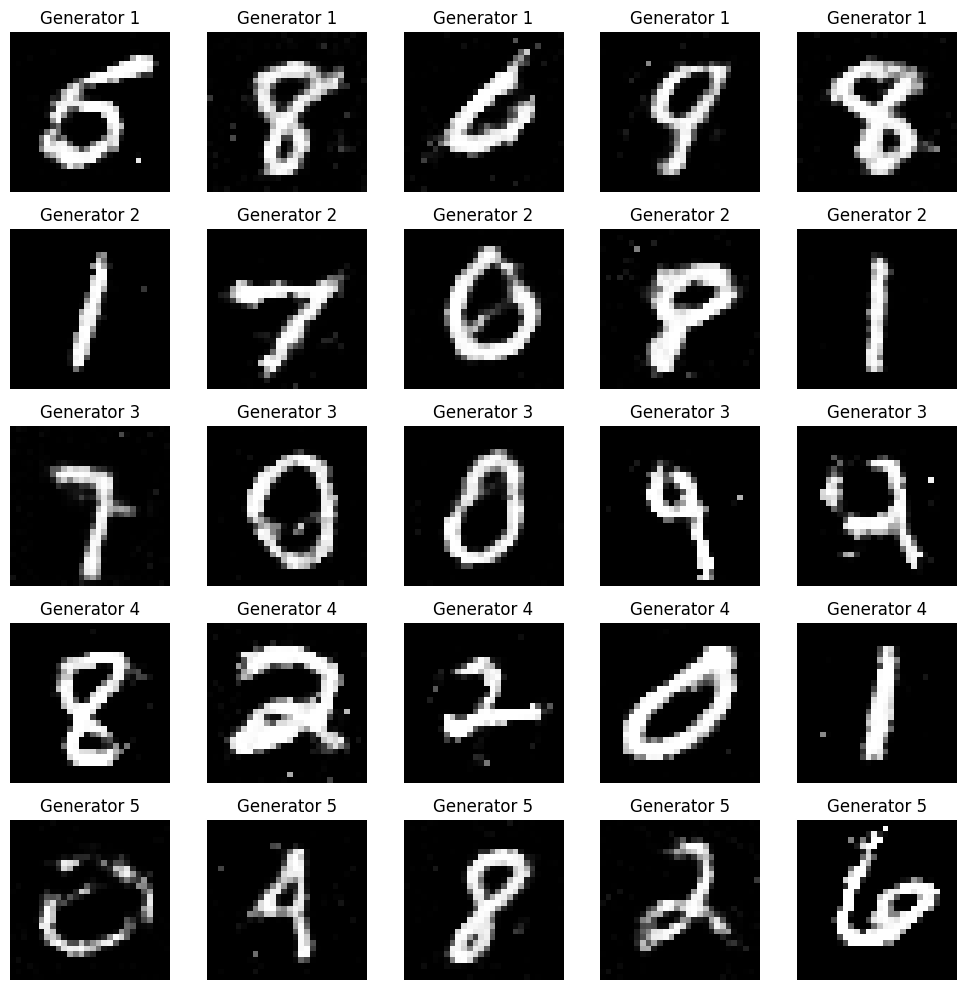

In [13]:

# Train the model
history = train_mgans(
    generators, discriminator, classifier,
    train_loader, latent_dim, num_epochs,
    beta, device, visualize_frequency
)


In [ ]:
# Plot training history
plot_training_history(history)
